# $r$ Estimation Code

This document provides a concise overview of the mathematical formulation used to estimate the tensor-to-scalar ratio $r$ by comparing the observed BB power spectrum with a model that includes primordial, lensing, and noise contributions.

In [5]:
import os

os.environ["EQX_ON_ERROR"] = "nan"

import sys

import camb
import healpy as hp
import jax
import jax.numpy as jnp
import jax.random
import matplotlib.pyplot as plt
import numpy as np
from furax._instruments.sky import get_noise_sigma_from_instrument
from furax.comp_sep._likelihoods import sky_signal
from furax.obs.landscapes import FrequencyLandscape, HealpixLandscape
from furax.obs.stokes import Stokes
from furax.obs.operators import NoiseDiagonalOperator

sys.path.append("../data")
from instruments import get_instrument

## Observed Angular Power Spectra  
This cell simulates a CMB I, Q, U map at NSIDE=64, computes its angular power spectra using anafast, and plots the TT, EE, BB, TE, TB, and EB spectra.

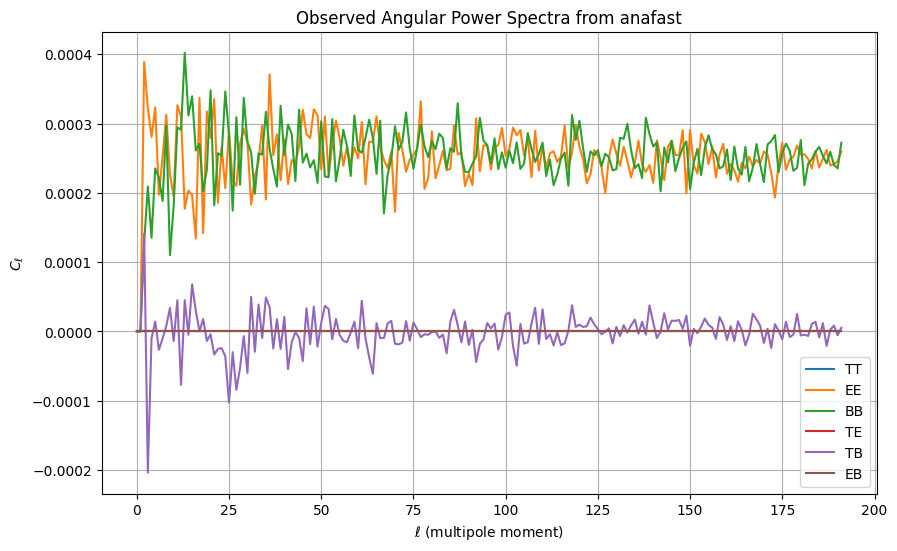

In [6]:
nside = 64
hp_landscape = HealpixLandscape(nside=nside, stokes="IQU")
mapp = hp_landscape.normal(jax.random.PRNGKey(0))
mapp = Stokes.from_stokes(jnp.zeros_like(mapp.i), mapp.q, mapp.u)
mapp = np.array(jnp.stack([mapp.i, mapp.q, mapp.u], axis=0))
a = hp.sphtfunc.anafast(mapp)
ell_obs = np.arange(a.shape[1])

plt.figure(figsize=(10, 6))
for i, label in enumerate(["TT", "EE", "BB", "TE", "TB", "EB"]):
    plt.plot(ell_obs, a[i], label=label)
plt.xlabel(r"$\ell$ (multipole moment)")
plt.ylabel(r"$C_\ell$")
plt.title("Observed Angular Power Spectra from anafast")
plt.legend()
plt.grid(True)
plt.show()

## Theoretical Cl's from CAMB  
This cell sets CAMB parameters and computes theoretical CMB power spectra, extracting the tensor BB template (for $r=1$), the total lensed BB spectrum, and the lensing-only BB spectrum.

In [7]:
pars = camb.set_params(
    ombh2=0.022,
    omch2=0.12,
    tau=0.054,
    As=2e-9,
    ns=0.965,
    cosmomc_theta=1.04e-2,
    r=1,
    DoLensing=True,
    WantTensors=True,
    Want_CMB_lensing=True,
    lmax=1024,
)
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit="muK", lmax=1024)
cl_bb_r1_full, cl_bb_total = powers["tensor"][:, 2], powers["total"][:, 2]
cl_bb_lens_full = cl_bb_total - cl_bb_r1_full

## Multipole Range and Normalization  
We select a multipole range $\ell$ from $\ell_{\min} = 2$ to $\ell_{\max} = 2 \times \text{NSIDE}$ and define:  
We then compute the normalization factor as:  
$$
\text{coeff} = \frac{\ell (\ell + 1)}{2\pi}
$$
so that the normalized power spectra are given by:  
$$
C_\ell^{BB,\text{norm}} = \frac{C_\ell^{BB}}{\text{coeff}}
$$
This normalization is applied to both the theoretical spectra (tensor and lensing) and the observed BB spectrum.

In [8]:
ell_min, ell_max = 2, nside * 2
ell_range = np.arange(ell_min, ell_max)
coeff = ell_range * (ell_range + 1) / (2 * np.pi)
cl_bb_r1_th, cl_bb_lens_th = cl_bb_r1_full[ell_range] / coeff, cl_bb_lens_full[ell_range] / coeff
cl_bb_obs = a[2][ell_range] / coeff

## Noise Template Generation and Its Role in the Likelihood  
We assume the observed data $d$ is a sum of the true sky signal $d_{\text{signal}}$ and noise $n$:  
$$
d = d_{\text{signal}} + n.
$$  
After applying the map-making operator $W$, we obtain the recovered map $s$:  
$$
s = W d = W d_{\text{signal}} + W n.
$$  
Here, $W n$ represents the noise contribution in the recovered map. In our code, we estimate the noise bias by generating multiple noise realizations, computing  
$$
N_e = \langle W n \rangle,
$$  
and then using the corresponding power spectrum $C_\ell^{BB,\,\text{noise}}$ in the likelihood model.

In [9]:
dust_nu0 = 160.0
synchrotron_nu0 = 20.0

noise_ratio = 0.2
noise_sim = 50
base_params = {
    "beta_dust": 1.54,
    "temp_dust": 20.0,
    "beta_pl": -3.0,
}

instrument = get_instrument("LiteBIRD")
nu = instrument.frequency
f_landscapes = FrequencyLandscape(nside, nu, "IQU")

sigma = get_noise_sigma_from_instrument(instrument, nside, stokes_type="IQU")
N = NoiseDiagonalOperator((sigma * noise_ratio) ** 2, _in_structure=f_landscapes.structure)


def Wn_sample(seed):
    white_noise = f_landscapes.normal(jax.random.key(seed)) * noise_ratio
    # white_noise = get_cutout_from_mask(white_noise, indices, axis=1)
    noise = white_noise * sigma
    Wn = sky_signal(base_params, nu, N, noise, dust_nu0=dust_nu0, synchrotron_nu0=synchrotron_nu0)
    return Wn["cmb"]


Wn = jax.vmap(Wn_sample)(jnp.arange(noise_sim))
Wn = jax.tree.map(lambda x: x.mean(axis=0), Wn)
Wn = np.array(jnp.stack([Wn.i, Wn.q, Wn.u], axis=0))
Wn_cl = hp.sphtfunc.anafast(Wn)
Wn_cl_bb = Wn_cl[2][ell_range]

## Explanation of the Likelihood and $r$ Estimation  

We model the theoretical BB power spectrum as  
$$
C_\ell^{\text{model}}(r) = r\, C_\ell^{BB,\text{tensor}} + C_\ell^{BB,\text{lensing}} + C_\ell^{BB,\text{noise}},
$$  
where:  
- $C_\ell^{BB,\text{tensor}}$ is the primordial tensor-mode BB spectrum for $r=1$ (scaled by $r$),  
- $C_\ell^{BB,\text{lensing}}$ is the lensing contribution,  
- $C_\ell^{BB,\text{noise}}$ is the noise bias estimated from simulations.  

The likelihood function is  
$$
-2\ln L(r) = f_{\mathrm{sky}} \sum_{\ell} (2\ell + 1) \left[ \frac{C_\ell^{\text{obs}}}{C_\ell^{\text{model}}(r)} + \ln C_\ell^{\text{model}}(r) \right].
$$  
Here, $f_{\mathrm{sky}}$ accounts for the fraction of the sky observed. It reduces the effective number of modes contributing to the sum, which affects the constraints on $r$.  

To estimate $r$, we maximize $L(r)$ by evaluating it over a grid of $r$ values. The best-fit $r$ is where $L(r)$ peaks, and the confidence intervals are computed using the cumulative likelihood distribution.  

Estimated r: 0.001061061061061061
Positive error: 0.00010010010010010019
Negative error: 9.009009009009004e-05


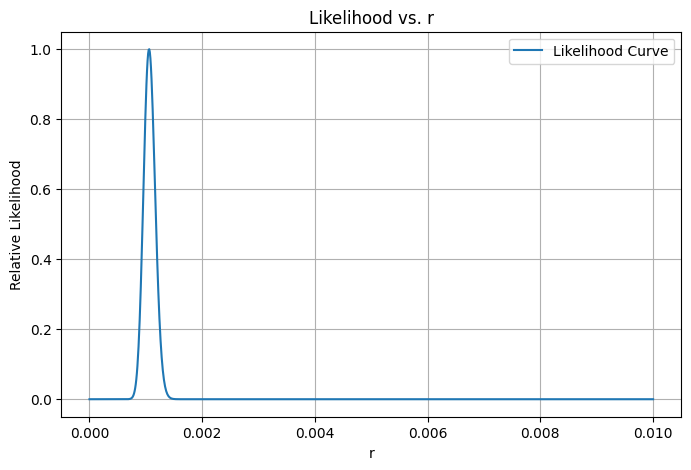

In [11]:
def log_likelihood(r, ell_range, cl_obs, cl_bb_r1, cl_bb_lens, Wn_cl_bb, f_sky):
    cl_model = r * cl_bb_r1 + cl_bb_lens + Wn_cl_bb
    likelihood_terms = (2 * ell_range + 1) * (cl_obs / cl_model + np.log(cl_model))
    return -0.5 * f_sky * np.sum(likelihood_terms)


def estimate_r(cl_obs, ell_range, cl_bb_r1, cl_bb_lens, Wn_cl_bb, r_grid, f_sky):
    r_best_list, sigma_r_pos_list, sigma_r_neg_list, L_values_list = [], [], [], []
    logL_grid = np.array(
        [
            log_likelihood(r, ell_range, cl_obs, cl_bb_r1, cl_bb_lens, Wn_cl_bb, f_sky)
            for r in r_grid
        ]
    )
    L = np.exp(logL_grid - np.max(logL_grid))
    r_best = r_grid[np.argmax(L)]

    rs_pos, L_pos = r_grid[r_grid > r_best], L[r_grid > r_best]
    cum_pos = np.cumsum(L_pos) / np.sum(L_pos)
    sigma_r_pos = rs_pos[np.argmin(np.abs(cum_pos - 0.68))] - r_best

    rs_neg, L_neg = r_grid[r_grid < r_best], L[r_grid < r_best]
    cum_neg = np.cumsum(L_neg[::-1]) / np.sum(L_neg)
    sigma_r_neg = r_best - rs_neg[::-1][np.argmin(np.abs(cum_neg - 0.68))]

    r_best_list.append(r_best)
    sigma_r_pos_list.append(sigma_r_pos)
    sigma_r_neg_list.append(sigma_r_neg)
    L_values_list.append(logL_grid)

    return r_best_list, sigma_r_pos_list, sigma_r_neg_list, L_values_list


# Define f_sky (e.g., 0.5 for half the sky)
f_sky = 0.5

r_grid = np.linspace(0, 0.01, 1000)
r_best, sigma_r_pos, sigma_r_neg, L_vals = estimate_r(
    cl_bb_obs, ell_range, cl_bb_r1_th, cl_bb_lens_th, Wn_cl_bb, r_grid, f_sky
)

print("Estimated r:", r_best[0])
print("Positive error:", sigma_r_pos[0])
print("Negative error:", sigma_r_neg[0])

plt.figure(figsize=(8, 5))
plt.plot(r_grid, np.exp(L_vals[0] - np.max(L_vals[0])), label="Likelihood Curve")
plt.xlabel("r")
plt.ylabel("Relative Likelihood")
plt.title("Likelihood vs. r")
plt.legend()
plt.grid(True)
plt.show()